This is based on the [EfficientNetB0 Starter](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43) notebook, modified for Pytorch. The original notebook is implemented in Tensorflow.

* Change to pytorch's Dataset and Dataloader
* Use efficientnet_b0 from torchvision
* Use pytorch lightning for building the model and training
* Inference using Trainer on multiple GPUs (DDP strategy) requires adding predictions gathering code, otherwise it will hang waiting for other nodes. So the raw pytorch's inference loop is used in the CV part. This needs to be done after training all the folds since the manual torch's GPU device initialization can't be mixed with lightning's DDP strategy.

In [1]:
import os
import sys
import gc
from time import time
import random
sys.path.append('/root/autodl-tmp/kaggle-kl-div')
from kaggle_kl_div import score
import typing as tp
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim import lr_scheduler
from torch.cuda import amp
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import KFold, GroupKFold
import timm
from pathlib import Path
import shutil
from tqdm.notebook import tqdm

In [2]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [3]:
class CFG:
    model_name = 'tf_efficientnet_b0_ns'#"resnet34d"
    img_size = 512
    max_epoch = 15
    batch_size = 32
    lr = 1.0e-03
    weight_decay = 1.0e-02
    es_patience =  10
    seed = 1086
    enable_amp = True
    device = "cuda"
    USE_KAGGLE_SPECTROGRAMS = True
    USE_EEG_SPECTROGRAMS = True
    READ_SPEC_FILES = False
    READ_EEG_SPEC_FILES = False
    READ_RAW_EEGS = False
    VER = 5
    data_type = 'both'

# Data Loading

In [4]:
def add_kl(data):
    import torch
    labels = data[TARGETS].values + 1e-5

    # compute kl-loss with uniform distribution by pytorch
    data['kl'] = torch.nn.functional.kl_div(
        torch.log(torch.tensor(labels)),
        torch.tensor([1 / 6] * 6),
        reduction='none'
    ).sum(dim=1).numpy()
    return data

In [5]:
train = pd.read_csv('/root/autodl-tmp/hms-harmful-brain-activity-classification/train.csv')
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

print('Train shape:', train.shape )
print('Targets', list(TARGETS))
print(train.head())
META = ['spectrogram_id','spectrogram_label_offset_seconds','patient_id','expert_consensus']
train = train.groupby('eeg_id')[META+TARGETS
                       ].agg({**{m:'first' for m in META},**{t:'sum' for t in TARGETS}}).reset_index() 
train[TARGETS] = train[TARGETS]/train[TARGETS].values.sum(axis=1,keepdims=True)
train.columns = ['eeg_id','spec_id','offset','patient_id','target'] + TARGETS
train = add_kl(train)
print(train.head(1).to_string())

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus 

In [6]:
train.shape

(17089, 12)

In [7]:


# READ ALL SPECTROGRAMS
PATH = '/root/autodl-tmp/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if CFG.READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i % 100 == 0:
            print(i, ', ', end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('/root/autodl-tmp/brain-spectrograms/specs.npy',allow_pickle=True).item()
    


if CFG.READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i % 100 == 0:
            print(i, ', ', end='')
        x = np.load(f'/root/autodl-tmp/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
#     all_eegs = np.load('/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()
    all_eegs = np.load('/root/autodl-tmp/eeg-spectrograms/eeg_specs.npy',allow_pickle=True).item()
    
if CFG.READ_RAW_EEGS:
    all_raw_eegs = np.load('/root/autodl-tmp/brain-eegs/eegs.npy',allow_pickle=True).item()
else:
    all_raw_eegs = None

There are 11138 spectrogram parquets


In [8]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x: y for y, x in TARS.items()}


class EEGDataset(Dataset):
    
    def __init__(self, data, augment=False, mode='train', specs=None, eeg_specs=None, raw_eegs=None, data_type='both'): 
        self.data = data
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.raw_eegs = raw_eegs
        self.data_type = data_type
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        X, y = self._generate_data(index)
        if self.augment:
            X = self._augment(X) 
#         if self.mode == 'train':
        return X, y
#         else:
#             return X
    
#     def __getitems__(self, index):
#         print(index)
#         X, y = self._generate_data(index)
#         if self.augment:
#             X = self._augment(X) 
#         return list(zip(X, y))
    
    def _generate_data(self, index):
        if self.data_type == 'both':
            X,y = self.generate_all_specs(index)
        elif self.data_type == 'eeg' or self.data_type == 'kaggle':
            X,y = self.generate_specs(index)
        elif self.data_type == 'raw':
            X,y = self.generate_raw(index)

        return X,y
        
    def generate_all_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
    
        row = self.data.iloc[index]
        if self.mode == 'test': 
            offset = 0
        else:
            offset = int(row.offset/2)
        eeg = self.eeg_specs[row.eeg_id]
        spec = self.specs[row.spec_id]
            
        imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in range(4)]
        img = np.stack(imgs,axis=-1)
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img,np.exp(-4),np.exp(8))
        img = np.log(img)

        # STANDARDIZE PER IMAGE
        img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,:256,0] = img[:,22:-22,2] # LP_k
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1] # RL_k
        X[100+56:200+56,:256,1] = img[:,22:-22,3] # RP_k

        X[0_0+56:100+56,256:,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,256:,0] = img[:,22:-22,1] # RL_k
        X[0_0+56:100+56,256:,1] = img[:,22:-22,2] # LP_k
        X[100+56:200+56,256:,1] = img[:,22:-22,3] # RP_K

        # EEG
        img = eeg
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        X[200+56:300+56,:256,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,:256,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,:256,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,:256,1] = img[:,22:-22,3] # RP_e

        X[200+56:300+56,256:,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,256:,0] = img[:,22:-22,1] # LP_e
        X[200+56:300+56,256:,1] = img[:,22:-22,2] # RL_e
        X[300+56:400+56,256:,1] = img[:,22:-22,3] # RP_e
        
        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
            
        if self.data_type == 'eeg':
            img = self.eeg_specs[row.eeg_id]
        elif self.data_type == 'kaggle':
            spec = self.specs[row.spec_id]
            imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in range(4)]
            img = np.stack(imgs,axis=-1)
            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img,np.exp(-4),np.exp(8))
            img = np.log(img)
            
            # STANDARDIZE PER IMAGE
            img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0]
        X[100+56:200+56,:256,0] = img[:,22:-22,2]
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1]
        X[100+56:200+56,:256,1] = img[:,22:-22,3]
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0]
        X[100+56:200+56,256:,0] = img[:,22:-22,1]
        X[0_0+56:100+56,256:,1] = img[:,22:-22,2]
        X[100+56:200+56,256:,1] = img[:,22:-22,3]
        
        X[200+56:300+56,:256,0] = img[:,22:-22,0]
        X[300+56:400+56,:256,0] = img[:,22:-22,2]
        X[200+56:300+56,:256,1] = img[:,22:-22,1]
        X[300+56:400+56,:256,1] = img[:,22:-22,3]
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0]
        X[300+56:400+56,256:,0] = img[:,22:-22,1]
        X[200+56:300+56,256:,1] = img[:,22:-22,2]
        X[300+56:400+56,256:,1] = img[:,22:-22,3]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_raw(self,index):
        X = np.zeros((10_000,8),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        eeg = self.raw_eegs[row.eeg_id]
            
        # FEATURE ENGINEER
        X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
        X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
        X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
        X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]
            
        X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
        X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]
            
        # STANDARDIZE
        X = np.clip(X,-1024,1024)
        X = np.nan_to_num(X, nan=0) / 32.0
            
        # BUTTER LOW-PASS FILTER
        X = self.butter_lowpass_filter(X)
        # Downsample
        X = X[::5,:]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
                
        return X,y
    
    
    def butter_lowpass_filter(self, data, cutoff_freq=20, sampling_rate=200, order=4):
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = lfilter(b, a, data, axis=0)
        return filtered_data
    
    def _random_transform(self, img):
        composition = albu.Compose([
#             albu.Resize(p=1.0, height=CFG.img_size, width=CFG.img_size),
            albu.HorizontalFlip(p=0.4),
            # albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
        ])
        return composition(image=img)['image']
            
    def _augment(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i,] = self._random_transform(img_batch[i,])
        return img_batch

In [9]:
dataset = EEGDataset(train,augment=False, specs=spectrograms, eeg_specs=all_eegs,data_type='both')
dataloader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=False)

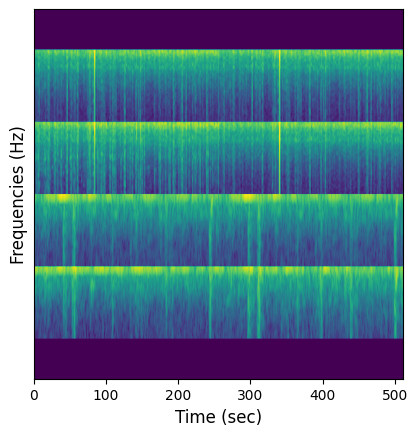

In [10]:
ROWS = 2
COLS = 3
BATCHES = 2

for i, (x,y) in enumerate(dataloader):
    break
plt.imshow(x[0,:,:,0])
# plt.title(f'Target = {y[0].round(1)}',size=12)
plt.yticks([])
plt.ylabel('Frequencies (Hz)',size=12)
plt.xlabel('Time (sec)',size=12)
plt.show()


In [11]:
del dataset, dataloader
gc.collect()

2719

# Training

In [12]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [13]:
# class HMSHBACSpecModel(nn.Module):

#     def __init__(
#             self,
#             model_name: str,
#             pretrained: bool,
#             in_channels: int,
#             num_classes: int,
#         ):
#         super().__init__()
# #         self.model = timm.create_model(
# #             model_name=model_name, pretrained=pretrained,
# #             num_classes=num_classes, in_chans=in_channels)
#         self.model = timm.create_model(
#             model_name=model_name, pretrained=pretrained, in_chans=in_channels)
#         in_features = self.model.classifier.in_features
#         self.model.classifier = nn.Identity()
#         self.model.global_pool = nn.Identity()
#         self.pooling = GeM()
#         self.linear = nn.Linear(in_features, num_classes)

#     def forward(self, x):   
#         x = torch.Tensor(x)
#         x = x.permute(0, 3, 1, 2)
#         features = self.model(x)
#         pooled_features = self.pooling(features).flatten(1)
#         out = self.linear(pooled_features)
#         return out

In [14]:
# class HMSHBACSpecModel(nn.Module):

#     def __init__(
#             self,
#             model_name: str,
#             pretrained: bool,
#             in_channels: int,
#             num_classes: int,
#         ):
#         super().__init__()
#         self.model = timm.create_model(
#             model_name=model_name, pretrained=pretrained,
#             num_classes=num_classes, in_chans=in_channels)


#     def forward(self, x):   
#         x = torch.Tensor(x)
#         x = x.permute(0, 3, 1, 2)
#         out = self.model(x)
#         return out

In [15]:
# class HMSHBACSpecModel(nn.Module):

#     def __init__(
#             self,
#             model_name: str,
#             pretrained: bool,
#             in_channels: int,
#             num_classes: int,
#         ):
#         super().__init__()
#         self.model = timm.create_model(
#             model_name=model_name, pretrained=pretrained, in_chans=in_channels)
#         in_features = self.model.classifier.in_features
#         self.model.classifier = nn.Identity()
#         self.linear = nn.Linear(in_features, num_classes)

#     def forward(self, x):   
#         x = torch.Tensor(x)
#         x = x.permute(0, 3, 1, 2)
#         features = self.model(x)
#         out = self.linear(features)
#         return out

In [16]:
# class HMSHBACSpecModel(nn.Module):

#     def __init__(
#             self,
#             model_name: str,
#             pretrained: bool,
#             in_channels: int,
#             num_classes: int,
#         ):
#         super().__init__()
#         self.backbone = timm.create_model(
#             model_name=model_name, pretrained=pretrained, in_chans=in_channels)
#         feature_info = self.backbone.feature_info
#         self.block_out_idx = [1, 2, 4]

#         self.aux_block1 = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.BatchNorm1d(feature_info[1]["num_chs"])
#         )
#         self.aux_block2 = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.BatchNorm1d(feature_info[2]["num_chs"])
#         )
#         self.aux_block4 = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.BatchNorm1d(feature_info[3]["num_chs"])
#         )

#         self.aux_linear1 = nn.Linear(feature_info[1]["num_chs"], num_classes)
#         self.aux_linear2 = nn.Linear(feature_info[2]["num_chs"], num_classes)
#         self.aux_linear4 = nn.Linear(feature_info[3]["num_chs"], num_classes)
#         self.num_features = (
#             self.backbone.num_features
#             + feature_info[1]["num_chs"]
#             + feature_info[2]["num_chs"]
#             + feature_info[3]["num_chs"]
#         )
#         self.linear = nn.Linear(self.num_features, num_classes)

#     def forward_features(self, x):
#         x = self.backbone.conv_stem(x)
#         x = self.backbone.bn1(x)
#         features = []
#         for i, b in enumerate(self.backbone.blocks):
#             x = b(x)
#             if i in self.block_out_idx:
#                 features.append(x)

#         features[0] = self.aux_block1(features[0])
#         features[1] = self.aux_block2(features[1])
#         features[2] = self.aux_block4(features[2])
#         features.append(self.backbone.global_pool(self.backbone.bn2(self.backbone.conv_head(x))))
#         return features


#     def forward(self, x):   
#         x = torch.Tensor(x)
#         x = x.permute(0, 3, 1, 2)
#         features = self.forward_features(x)
#         features = torch.cat(features, dim=1)
        
#         out = self.linear(features)
#         return out

In [17]:
class HMSHBACSpecModel(nn.Module):

    def __init__(
            self,
            model_name: str,
            pretrained: bool,
            in_channels: int,
            num_classes: int,
        ):
        super().__init__()
        self.model = timm.create_model(
            model_name=model_name, pretrained=pretrained, in_chans=in_channels)
        print(self.model)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes),

        )
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, x):   
        x = torch.Tensor(x)
        x = x.permute(0, 3, 1, 2)
        features = self.model(x)
        out = self.mlp(features)
        return out

In [18]:
class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss
    
class KLDivLossWithLogitsForVal(nn.KLDivLoss):
    
    def __init__(self):
        """"""
        super().__init__(reduction="batchmean")
        self.log_prob_list  = []
        self.label_list = []

    def forward(self, y, t):
        y = nn.functional.log_softmax(y, dim=1)
        self.log_prob_list.append(y.cpu().numpy())
        self.label_list.append(t.cpu().numpy())
        
    def compute(self):
        log_prob = np.concatenate(self.log_prob_list, axis=0)
        label = np.concatenate(self.label_list, axis=0)
        final_metric = super().forward(
            torch.from_numpy(log_prob),
            torch.from_numpy(label)
        ).item()
        self.log_prob_list = []
        self.label_list = []
        
        return final_metric

In [19]:
def set_random_seed(seed: int = 42):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False
def to_device(
    tensors: tp.Union[tp.Tuple[torch.Tensor], tp.Dict[str, torch.Tensor]],
    device: torch.device, *args, **kwargs
):
    if isinstance(tensors, tuple):
        return (t.to(device, *args, **kwargs) for t in tensors)
    elif isinstance(tensors, dict):
        return {
            k: t.to(device, *args, **kwargs) for k, t in tensors.items()}
    else:
        return tensors.to(device, *args, **kwargs)

In [20]:
def train_one_fold(CFG, fold,train_index, valid_index, output_path,stage='first'):
    """Main"""
    set_random_seed(CFG.seed)
    device = torch.device(CFG.device)
    model = HMSHBACSpecModel(
        model_name=CFG.model_name, pretrained=True, num_classes=6, in_channels=3)
    model.to(device)
    
    train_data, valid_data = train.iloc[train_index], train.iloc[valid_index]
    train_ds = EEGDataset(data=train_data, augment=False, mode='train', specs=spectrograms, eeg_specs=all_eegs, raw_eegs=all_raw_eegs, data_type=CFG.data_type)
    train_loader = DataLoader(train_ds, shuffle=True, batch_size=CFG.batch_size, num_workers=10)
    valid_ds = EEGDataset(valid_data, mode='valid', specs=spectrograms, eeg_specs=all_eegs, raw_eegs=all_raw_eegs, data_type=CFG.data_type)
    val_loader = DataLoader(valid_ds, shuffle=False, batch_size=CFG.batch_size*2, num_workers=10)
    
    if stage !='first':
        train_data= train_data[train_data['kl']<5.5]
        train_ds = EEGDataset(data=train_data, augment=False, mode='train', specs=spectrograms, eeg_specs=all_eegs, raw_eegs=all_raw_eegs, data_type=CFG.data_type)
        train_loader = DataLoader(train_ds, shuffle=True, batch_size=CFG.batch_size, num_workers=10)
        model_path = './'+ f"best_model_fold{fold}.pth"
        model.load_state_dict(torch.load(model_path, map_location=device))
        print('init success')
    print(f'### Train size: {len(train_index)}, Valid size: {len(valid_index)}')
    print('#'*25)
    

    
    optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = lr_scheduler.OneCycleLR(
        optimizer=optimizer, epochs=CFG.max_epoch,
        pct_start=0.0, steps_per_epoch=len(train_loader),
        max_lr=CFG.lr, div_factor=25, final_div_factor=4.0e-01
    )
    
    loss_func = KLDivLossWithLogits()
    loss_func.to(device)
    loss_func_val = KLDivLossWithLogitsForVal()
    
    use_amp = CFG.enable_amp
    scaler = amp.GradScaler(enabled=use_amp)
    
    best_val_loss = 1.0e+09
    best_epoch = 0
    train_loss = 0
    for epoch in range(1, CFG.max_epoch + 1):
        epoch_start = time()
        model.train()
        for batch in train_loader:
#             batch = to_device(batch, device)
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            optimizer.zero_grad()
            with amp.autocast(use_amp):
                y = model(x)
                loss = loss_func(y, t)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
            
        model.eval()
        for batch in val_loader:
#             batch = to_device(batch, device)
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            with torch.no_grad(), amp.autocast(use_amp):
                y = model(x)
            y = y.detach().cpu().to(torch.float32)
            loss_func_val(y, t)
        val_loss = loss_func_val.compute() 
        if val_loss < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            # print("save model")
            torch.save(model.state_dict(), str(output_path / f'snapshot_epoch_{epoch}.pth'))
        
        elapsed_time = time() - epoch_start
        print(
            f"[epoch {epoch}] train loss: {train_loss: .6f}, val loss: {val_loss: .6f}, elapsed_time: {elapsed_time: .3f}")
        
        if epoch - best_epoch > CFG.es_patience:
            print("Early Stopping!")
            break
            
        train_loss = 0
            
    return fold, best_epoch, best_val_loss

In [24]:
score_list = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    print('#'*25)
    print(f'###  Fold {i}')
    
    output_path = Path(f"fold{i}")
    output_path.mkdir(exist_ok=True)
    print(f"[fold{i}]")     
    score_list.append(train_one_fold(CFG, i,train_index, valid_index, output_path))
    # score_list.append(train_one_fold(CFG, i,train_index, valid_index, output_path, stage='sec'))

#########################
###  Fold 0
[fold0]


/root/miniconda3/lib/python3.8/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


ProxyError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/tf_efficientnet_b0.ns_jft_in1k/resolve/main/model.safetensors (Caused by ProxyError('Cannot connect to proxy.', timeout('_ssl.c:1114: The handshake operation timed out')))"), '(Request ID: 3ea57093-3865-467e-b330-6ccf8397bb65)')

Inference Out Of Fold
Copy best models

In [ ]:
print(score_list)

In [ ]:
best_log_list = []
for (fold_id, best_epoch, _) in score_list:
    
    exp_dir_path = Path(f"fold{fold_id}")
    best_model_path = exp_dir_path / f"snapshot_epoch_{best_epoch}.pth"
    copy_to = f"./best_model_fold{fold_id}.pth"
    shutil.copy(best_model_path, copy_to)
    
    for p in exp_dir_path.glob("*.pth"):
        p.unlink()

Inference OOF

In [ ]:
def run_inference_loop(model, loader, device):
    model.to(device)
    model.eval()
    pred_list = []
    with torch.no_grad():
        for batch in tqdm(loader):
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            pred_list.append(y.softmax(dim=1).detach().cpu().numpy())
        
    pred_arr = np.concatenate(pred_list)
    del pred_list
    return pred_arr

In [ ]:
device = torch.device(CFG.device)

In [ ]:
all_oof = []
all_true = []
valid_loaders = []
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    print('#'*25)
    print(f'### Fold {i+1}')
    valid_data = train.iloc[valid_index]

    valid_ds = EEGDataset(valid_data, mode='valid', specs=spectrograms, eeg_specs=all_eegs, raw_eegs=all_raw_eegs, data_type='both')
    valid_loader = DataLoader(valid_ds, shuffle=False, batch_size=CFG.batch_size*2, num_workers=3)
    print(f'###  Valid size: {len(valid_index)}')
    print('#'*25)
    
    # # get model
    model_path = f"./best_model_fold{i}.pth"
    model = HMSHBACSpecModel(
        model_name=CFG.model_name, pretrained=False, num_classes=6, in_channels=3)
    model.to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # # inference
    val_pred = run_inference_loop(model, valid_loader, device)
    valid_loaders.append(valid_loader)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    all_oof.append(val_pred)
    del model
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

In [ ]:
oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print(f'CV Score KL-Div for {CFG.model_name} =',cv)

In [ ]:
# # WEIGHTS_FILE = '/kaggle/input/hms-efficientnetb0-pt-ckpts/efficientnet_b0_rwightman-7f5810bc.pth'


# class HMSModel(pl.LightningModule):
    
#     def __init__(
#         self,
#         model_name: str,
#         pretrained: bool,
#         in_channels: int,
#         num_classes: int,
    
#     ):
#         super().__init__()
#         self.base_model = timm.create_model(
#             model_name=model_name, pretrained=pretrained,
#             num_classes=num_classes, in_chans=in_channels)
#         self.prob_out = nn.Softmax()
        
#     def forward(self, x):
#         x1 = [x[:, :, :, i:i+1] for i in range(4)]
#         x1 = torch.concat(x1, dim=1)
#         x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
#         x2 = torch.concat(x2, dim=1)
        
#         if CFG.USE_KAGGLE_SPECTROGRAMS & CFG.USE_EEG_SPECTROGRAMS:
#             x = torch.concat([x1, x2], dim=2)
#         elif CFG.USE_EEG_SPECTROGRAMS:
#             x = x2
#         else:
#             x = x1
#         x = torch.concat([x, x, x], dim=3)
#         x = x.permute(0, 3, 1, 2)
        
#         out = self.base_model(x)
#         return out
    
#     def training_step(self, batch, batch_idx):
#         x, y = batch
    
#         out = self.forward(x)
#         out = F.log_softmax(out, dim=1)
#         kl_loss = nn.KLDivLoss(reduction='batchmean')
#         loss = kl_loss(out, y)
#         return loss
    
#     def predict_step(self, batch, batch_idx, dataloader_idx=0):
#         return F.softmax(self(batch), dim=1)
    
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=CFG.lr)
#         return optimizer

In [ ]:
# all_oof = []
# all_true = []
# valid_loaders = []

# gkf = GroupKFold(n_splits=5)
# for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
#     print('#'*25)
#     print(f'### Fold {i+1}')
    
#     train_ds = EEGDataset(train.iloc[train_index])
#     train_loader = DataLoader(train_ds, shuffle=True, batch_size=CFG.batch_size, num_workers=3)
#     valid_ds = EEGDataset(train.iloc[valid_index], mode='valid')
#     valid_loader = DataLoader(valid_ds, shuffle=False, batch_size=CFG.batch_size*2, num_workers=3)
    
#     print(f'### Train size: {len(train_index)}, Valid size: {len(valid_index)}')
#     print('#'*25)
    
#     trainer = pl.Trainer(max_epochs=CFG.max_epoch)
#     model = HMSModel(model_name=CFG.model_name, pretrained=True, num_classes=6, in_channels=3)
#     if LOAD_MODELS_FROM is None:
#         trainer.fit(model=model, train_dataloaders=train_loader)
#         # 手动保存模型权重
#         trainer.save_checkpoint(f'{CFG.model_name}_v{CFG.VER}_f{i}.ckpt')

#     valid_loaders.append(valid_loader)
#     all_true.append(train.iloc[valid_index][TARGETS].values)
#     del trainer
#     gc.collect()

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# for i in range(5):
#     print('#'*25)
#     print(f'### Validating Fold {i+1}')

#     ckpt_file = f'{CFG.model_name}_v{CFG.VER}_f{i}.ckpt' if LOAD_MODELS_FROM is None else f'{LOAD_MODELS_FROM}/{CFG.model_name}_v{CFG.VER}_f{i}.ckpt'
#     model = model.load_from_cxheckpoint(ckpt_file)
#     model.to(device).eval()
#     with torch.inference_mode():
#         for val_batch in valid_loaders[i]:
#             val_batch = val_batch.to(device)
#             oof = torch.softmax(model(val_batch), dim=1).cpu().numpy()
#             all_oof.append(oof)
#     del model
#     gc.collect()

# all_oof = np.concatenate(all_oof)
# all_true = np.concatenate(all_true)

In [ ]:
# oof = pd.DataFrame(all_oof.copy())
# oof['id'] = np.arange(len(oof))

# true = pd.DataFrame(all_true.copy())
# true['id'] = np.arange(len(true))

# cv = score(solution=true, submission=oof, row_id_column_name='id')
# print('CV Score KL-Div for EfficientNetB2 =',cv)

# Inference

In [ ]:
# del all_eegs, spectrograms
# gc.collect()

# test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
# print('Test shape',test.shape)
# test.head()

In [ ]:
# # READ ALL SPECTROGRAMS
# PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
# files2 = os.listdir(PATH2)
# print(f'There are {len(files2)} test spectrogram parquets')
    
# spectrograms2 = {}
# for i, f in enumerate(files2):
#     if i % 100 == 0:
#         print(i, ', ',end='')
#     tmp = pd.read_parquet(f'{PATH2}{f}')
#     name = int(f.split('.')[0])
#     spectrograms2[name] = tmp.iloc[:, 1:].values
    
# # RENAME FOR DATALOADER
# test = test.rename({'spectrogram_id': 'spec_id'}, axis=1)

In [ ]:
# import pywt, librosa

# USE_WAVELET = None 

# NAMES = ['LL','LP','RP','RR']

# FEATS = [['Fp1','F7','T3','T5','O1'],
#          ['Fp1','F3','C3','P3','O1'],
#          ['Fp2','F8','T4','T6','O2'],
#          ['Fp2','F4','C4','P4','O2']]


# # DENOISE FUNCTION
# def maddest(d, axis=None):
#     return np.mean(np.absolute(d - np.mean(d, axis)), axis)


# def denoise(x, wavelet='haar', level=1):    
#     coeff = pywt.wavedec(x, wavelet, mode="per")
#     sigma = (1/0.6745) * maddest(coeff[-level])

#     uthresh = sigma * np.sqrt(2*np.log(len(x)))
#     coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

#     ret=pywt.waverec(coeff, wavelet, mode='per')
    
#     return ret


# def spectrogram_from_eeg(parquet_path, display=False):
    
#     # LOAD MIDDLE 50 SECONDS OF EEG SERIES
#     eeg = pd.read_parquet(parquet_path)
#     middle = (len(eeg)-10_000)//2
#     eeg = eeg.iloc[middle:middle+10_000]
    
#     # VARIABLE TO HOLD SPECTROGRAM
#     img = np.zeros((128,256,4),dtype='float32')
    
#     if display: plt.figure(figsize=(10,7))
#     signals = []
#     for k in range(4):
#         COLS = FEATS[k]
        
#         for kk in range(4):
        
#             # COMPUTE PAIR DIFFERENCES
#             x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

#             # FILL NANS
#             m = np.nanmean(x)
#             if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
#             else: x[:] = 0

#             # DENOISE
#             if USE_WAVELET:
#                 x = denoise(x, wavelet=USE_WAVELET)
#             signals.append(x)

#             # RAW SPECTROGRAM
#             mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
#                   n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

#             # LOG TRANSFORM
#             width = (mel_spec.shape[1]//32)*32
#             mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

#             # STANDARDIZE TO -1 TO 1
#             mel_spec_db = (mel_spec_db+40)/40 
#             img[:,:,k] += mel_spec_db
                
#         # AVERAGE THE 4 MONTAGE DIFFERENCES
#         img[:,:,k] /= 4.0
        
#         if display:
#             plt.subplot(2,2,k+1)
#             plt.imshow(img[:,:,k],aspect='auto',origin='lower')
#             plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
#     if display: 
#         plt.show()
#         plt.figure(figsize=(10,5))
#         offset = 0
#         for k in range(4):
#             if k>0: offset -= signals[3-k].min()
#             plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
#             offset += signals[3-k].max()
#         plt.legend()
#         plt.title(f'EEG {eeg_id} Signals')
#         plt.show()
#         print(); print('#'*25); print()
        
#     return img

In [ ]:
# # READ ALL EEG SPECTROGRAMS
# PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
# DISPLAY = 1
# EEG_IDS2 = test.eeg_id.unique()
# all_eegs2 = {}

# print('Converting Test EEG to Spectrograms...'); print()
# for i, eeg_id in enumerate(EEG_IDS2):
        
#     # CREATE SPECTROGRAM FROM EEG PARQUET
#     img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i < DISPLAY)
#     all_eegs2[eeg_id] = img

In [ ]:
# # INFER EFFICIENTNET ON TEST
# preds = []
# test_ds = EEGDataset(test, mode='test', specs=spectrograms2, eeg_specs=all_eegs2)
# test_loader = DataLoader(test_ds, shuffle=False, batch_size=64, num_workers=3)

# for i in range(5):
#     print('#'*25)
#     print(f'### Testing Fold {i+1}')

#     ckpt_file = f'{CFG.model_name}_v{CFG.VER}_f{i}.ckpt' if LOAD_MODELS_FROM is None else f'{LOAD_MODELS_FROM}/{CFG.model_name}_v{CFG.VER}_f{i}.ckpt'
#     model = EEGEffnetB0.load_from_checkpoint(ckpt_file)
#     model.to(device).eval()
#     fold_preds = []

#     with torch.inference_mode():
#         for test_batch in test_loader:
#             test_batch = test_batch.to(device)
#             pred = torch.softmax(model(test_batch), dim=1).cpu().numpy()
#             fold_preds.append(pred)
#         fold_preds = np.concatenate(fold_preds)

#     preds.append(fold_preds)

# pred = np.mean(preds,axis=0)
# print()
# print('Test preds shape',pred.shape)

In [ ]:
# sub = pd.DataFrame({'eeg_id': test.eeg_id.values})
# sub[TARGETS] = pred
# sub.to_csv('submission.csv',index=False)
# print('Submissionn shape',sub.shape)
# sub.head()

In [ ]:
# # SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
# sub.iloc[:,-6:].sum(axis=1)